In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
merged_df = pd.read_csv('merged.csv')

In [3]:
merged_df.head()

,Unnamed: 0,Date,XOM-Price,XOM-Yield,TSLA-Price,TSLA-Yield,LLY-Price,LLY-Yield,AAPL-Price,AAPL-Yield,...,Govt_Yield,XOM-spread,TSLA-spread,LLY-spread,AAPL-spread,NVDA-spread,JPM-spread,AMZN-spread,V-spread,UNH-spread
0,0,2019-01-02,96.727,3.299,69.879,11.403,96.732,3.320,100.954,3.253,...,2.633,0.666,8.770,0.687,0.620,1.248,1.467,0.645,0.712,0.804
1,1,2019-01-03,97.207,3.212,70.389,11.270,96.941,3.283,101.039,3.236,...,2.552,0.660,8.718,0.731,0.684,1.281,1.519,0.686,0.757,0.788
2,2,2019-01-04,96.661,3.312,71.510,10.967,96.669,3.332,100.570,3.332,...,2.668,0.644,8.299,0.664,0.664,1.274,1.447,0.667,0.737,0.770
3,3,2019-01-07,96.522,3.338,73.343,10.482,96.387,3.383,100.582,3.329,...,2.698,0.640,7.784,0.685,0.631,1.239,1.398,0.648,0.697,0.753
4,4,2019-01-08,96.228,3.393,74.650,10.145,96.293,3.400,100.506,3.345,...,2.730,0.663,7.415,0.670,0.615,1.216,1.361,0.650,0.691,0.724


In [4]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

companies = set(col.split('-')[0] for col in merged_df.columns if 'Price' in col)

In [5]:
merged_df.head()

,Unnamed: 0,Date,XOM-Price,XOM-Yield,TSLA-Price,TSLA-Yield,LLY-Price,LLY-Yield,AAPL-Price,AAPL-Yield,...,Govt_Yield,XOM-spread,TSLA-spread,LLY-spread,AAPL-spread,NVDA-spread,JPM-spread,AMZN-spread,V-spread,UNH-spread
0,0,2019-01-02,96.727,3.299,69.879,11.403,96.732,3.320,100.954,3.253,...,2.633,0.666,8.770,0.687,0.620,1.248,1.467,0.645,0.712,0.804
1,1,2019-01-03,97.207,3.212,70.389,11.270,96.941,3.283,101.039,3.236,...,2.552,0.660,8.718,0.731,0.684,1.281,1.519,0.686,0.757,0.788
2,2,2019-01-04,96.661,3.312,71.510,10.967,96.669,3.332,100.570,3.332,...,2.668,0.644,8.299,0.664,0.664,1.274,1.447,0.667,0.737,0.770
3,3,2019-01-07,96.522,3.338,73.343,10.482,96.387,3.383,100.582,3.329,...,2.698,0.640,7.784,0.685,0.631,1.239,1.398,0.648,0.697,0.753
4,4,2019-01-08,96.228,3.393,74.650,10.145,96.293,3.400,100.506,3.345,...,2.730,0.663,7.415,0.670,0.615,1.216,1.361,0.650,0.691,0.724


In [6]:
def calculate_smas(data, short_window=10, long_window=50):
    for company in companies:
        spread_col = f'{company}-spread'  # Adjusted to match provided data
        
        # Calculate SMAs
        data[f'{company}-SMA_{short_window}'] = data[spread_col].rolling(window=short_window, min_periods = 1).mean()
        data[f'{company}-SMA_{long_window}'] = data[spread_col].rolling(window=long_window, min_periods = 1).mean()

# Call the SMA calculation function
calculate_smas(merged_df)

indicate where the trades are by adding in markers - look at medium for this

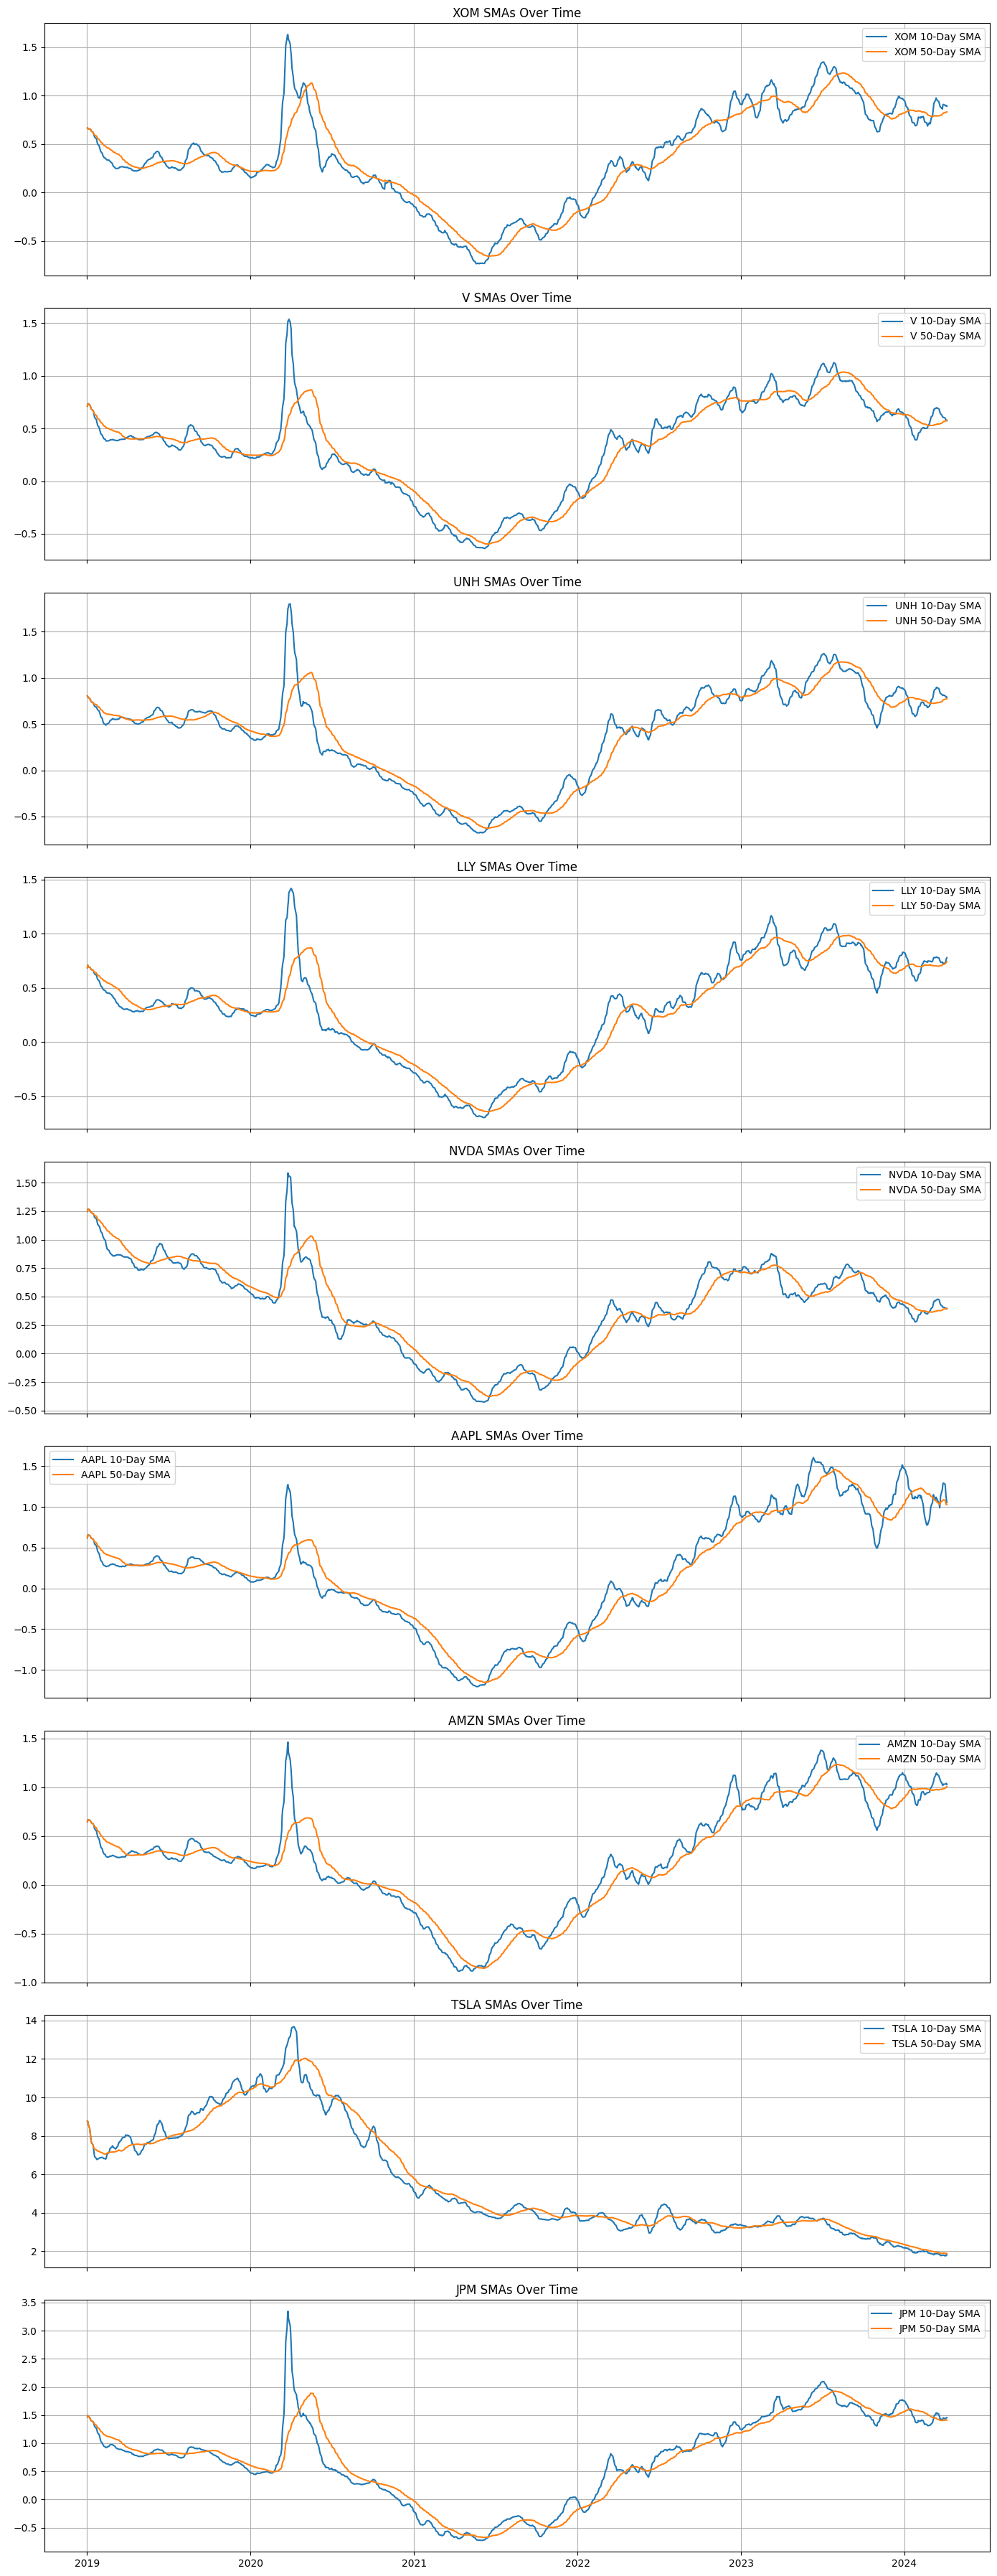

In [7]:
merged_df.set_index('Date', inplace=True)

# Find all unique companies from the 'Price' columns
companies = set(col.split('-')[0] for col in merged_df.columns if '-Price' in col)

# Plot short and long term SMAs for each company
fig, axes = plt.subplots(len(companies), 1, figsize=(14, 4 * len(companies)), sharex=True)

# Check if there's only one company, not to index axes which becomes an AxesSubplot instead of array of AxesSubplot
single_company = len(companies) == 1

for i, company in enumerate(companies):
    # Select the appropriate axis for the plot
    ax = axes[i] if not single_company else axes
    
    # Plotting the short-term and long-term SMAs
    sma_short_col = f'{company}-SMA_10'
    sma_long_col = f'{company}-SMA_50'
    
    ax.plot(merged_df.index, merged_df[sma_short_col], label=f'{company} 10-Day SMA')
    ax.plot(merged_df.index, merged_df[sma_long_col], label=f'{company} 50-Day SMA')
    ax.set_title(f'{company} SMAs Over Time')
    ax.legend()
    ax.grid(True)

# Improve spacing between plots
plt.tight_layout()
#plt.show()

In [8]:
# Backtesting Function
def backtest_strategy_with_interest(data, initial_investment=10000, short_window=10, long_window=50):
    calculate_smas(data, short_window, long_window)
    cash = initial_investment
    holdings = {company: 0 for company in companies}
    portfolio_values = []

    differences = {}
    for company in companies:
        differences[company] = 0

    differences_prev = {}
    for company in companies:
        differences_prev[company] = 0

    crossed = {}
    for company in companies:
        crossed[company] = False
    
    #buy only after crossovers occur
    #not buying or selling one bond on each date
    for date, row in data.iterrows():
        for company in companies:
            price_col = f'{company}-Price'
            yield_col = f'{company}-Yield'
            sma_short = f'{company}-SMA_{short_window}'
            sma_long = f'{company}-SMA_{long_window}'

            differences_prev = differences.copy()
            differences[company] = row[sma_short] - row[sma_long]

            if (differences_prev[company] < 0 and differences[company] > 0) or (differences_prev[company] > 0 and differences[company] < 0):
                crossed[company] = True

            #print(differences)

            # Check for a crossover and adjust holdings accordingly
            if row[sma_short] > row[sma_long] and cash >= row[price_col] and crossed[company]:
                # Buy one bond
                holdings[company] += 1
                cash -= row[price_col]
            elif row[sma_short] < row[sma_long] and holdings[company] > 0 and crossed[company]:
                # Sell one bond
                holdings[company] -= 1
                cash += row[price_col]

        # Calculate the daily portfolio value
        daily_portfolio_value = cash + sum(holdings[company] * row[price_col] for company in companies)
        portfolio_values.append(daily_portfolio_value)

    portfolio_value_df = pd.DataFrame(portfolio_values, index=data.index, columns=['Portfolio Value'])
    
    return portfolio_value_df, holdings, cash

# Perform the backtest starting from 5 years ago
start_date = merged_df.index.max() - pd.DateOffset(years=5)
backtest_data = merged_df.loc[start_date:]
portfolio_value_df, holdings, cash = backtest_strategy_with_interest(backtest_data)


/var/folders/dc/zvwyc6hj1lb8z33y8dt2g0jw0000gn/T/ipykernel_1044/2849789107.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{company}-SMA_{short_window}'] = data[spread_col].rolling(window=short_window, min_periods = 1).mean()
/var/folders/dc/zvwyc6hj1lb8z33y8dt2g0jw0000gn/T/ipykernel_1044/2849789107.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{company}-SMA_{long_window}'] = data[spread_col].rolling(window=long_window, min_periods = 1).mean()


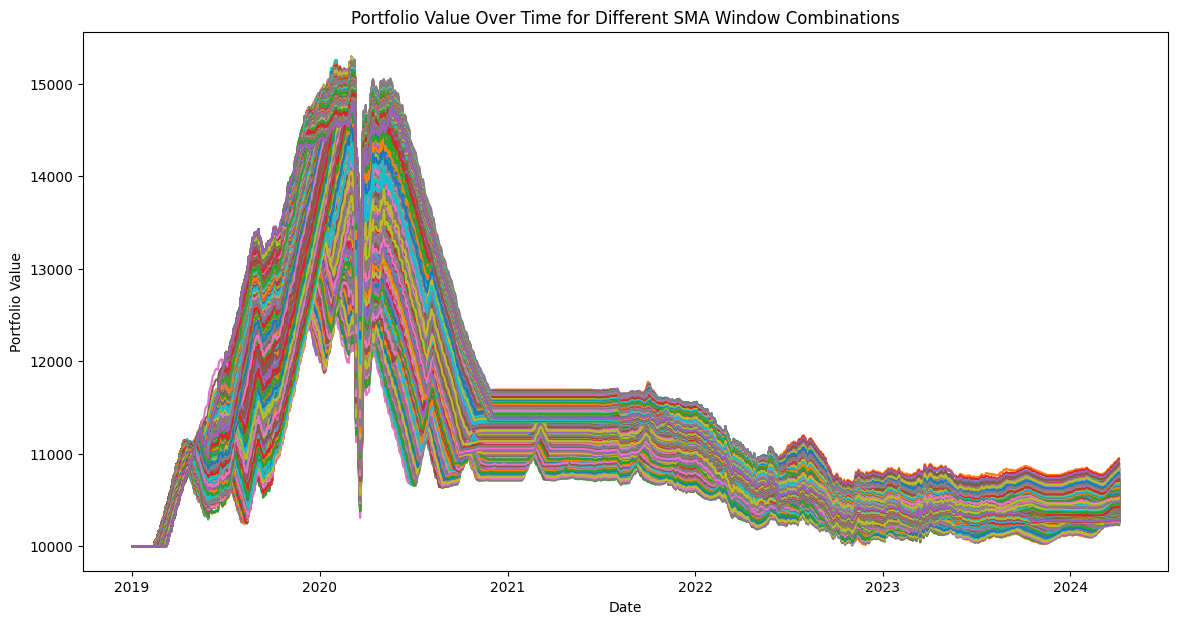

In [9]:
def monte_carlo_simulation(data, short_window_range, long_window_range, initial_investment=10000):
    best_performance = 0
    best_windows = (0, 0)
    simulation_results = {}  # Store the time series for each simulation
    
    for short_window in short_window_range:
        for long_window in long_window_range:
            if short_window < long_window:  # Ensure the short window is shorter than the long window
                data_copy = data.copy()
                portfolio_value_df, _, _ = backtest_strategy_with_interest(data_copy, initial_investment, short_window, long_window)
                final_portfolio_value = portfolio_value_df['Portfolio Value'].iloc[-1]
                
                # Store the time series for plotting
                key = f"SW_{short_window}_LW_{long_window}"
                simulation_results[key] = portfolio_value_df['Portfolio Value']
                
                if final_portfolio_value > best_performance:
                    best_performance = final_portfolio_value
                    best_windows = (short_window, long_window)
                    
    return best_windows, best_performance, simulation_results

# Define the range of SMA windows to test
short_window_range = range(5, 31)  # For example: 5 to 20 days
long_window_range = range(30, 201)  # For example: 20 to 50 days

# Perform the Monte Carlo simulation (assuming merged_df is your DataFrame)
best_sma_windows, best_performance, simulation_results = monte_carlo_simulation(merged_df, short_window_range, long_window_range)

# Plotting all simulations
plt.figure(figsize=(14, 7))
for key, series in simulation_results.items():
    plt.plot(series.index, series, label=key)

plt.title('Portfolio Value Over Time for Different SMA Window Combinations')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
#plt.legend(loc='upper left', fontsize='xx-small')
plt.show()

In [119]:
# Benchmarking against equal amount invested in each bond with yearly interest payouts
def calculate_benchmark_portfolio(data, initial_investment=10000):
    investment_per_bond = initial_investment / len(companies)
    yearly_interest = {company: 0 for company in companies}
    portfolio_values = []
    year_flag = 2019

    for date, row in data.iterrows():
        # Check if it's the start of the year to reset the interest calculation
        
        if year_flag != date.year:
            for company in companies:
                price_col = f'{company}-Price'
                yield_col = f'{company}-Yield'
                yearly_interest[company] = (row[yield_col] / 100) * row[price_col]
        
        year_flag = date.year

        # Calculate the daily portfolio value considering the yearly interest payout
        daily_portfolio_value = sum(investment_per_bond + yearly_interest[company] for company in companies)
        portfolio_values.append(daily_portfolio_value)

    benchmark_portfolio_df = pd.DataFrame(portfolio_values, index=data.index, columns=['Benchmark Portfolio'])
    return benchmark_portfolio_df

benchmark_portfolio_df = calculate_benchmark_portfolio(backtest_data)

# Combine the backtest portfolio and benchmark portfolio
combined_portfolio_df = pd.concat([portfolio_value_df, benchmark_portfolio_df], axis=1)

combined_portfolio_df.head(), holdings, cash

(            Portfolio Value  Benchmark Portfolio
 Date                                            
 2019-04-05          10000.0              10000.0
 2019-04-08          10000.0              10000.0
 2019-04-09          10000.0              10000.0
 2019-04-10          10000.0              10000.0
 2019-04-11          10000.0              10000.0,
 {'AMZN': 13,
  'V': 14,
  'TSLA': 0,
  'UNH': 13,
  'AAPL': 7,
  'NVDA': 14,
  'LLY': 28,
  'XOM': 9,
  'JPM': 6},
 90.72899999999508)

/var/folders/dc/zvwyc6hj1lb8z33y8dt2g0jw0000gn/T/ipykernel_7182/3132842733.py:30: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = (1 + daily_returns).resample('Y').prod() - 1


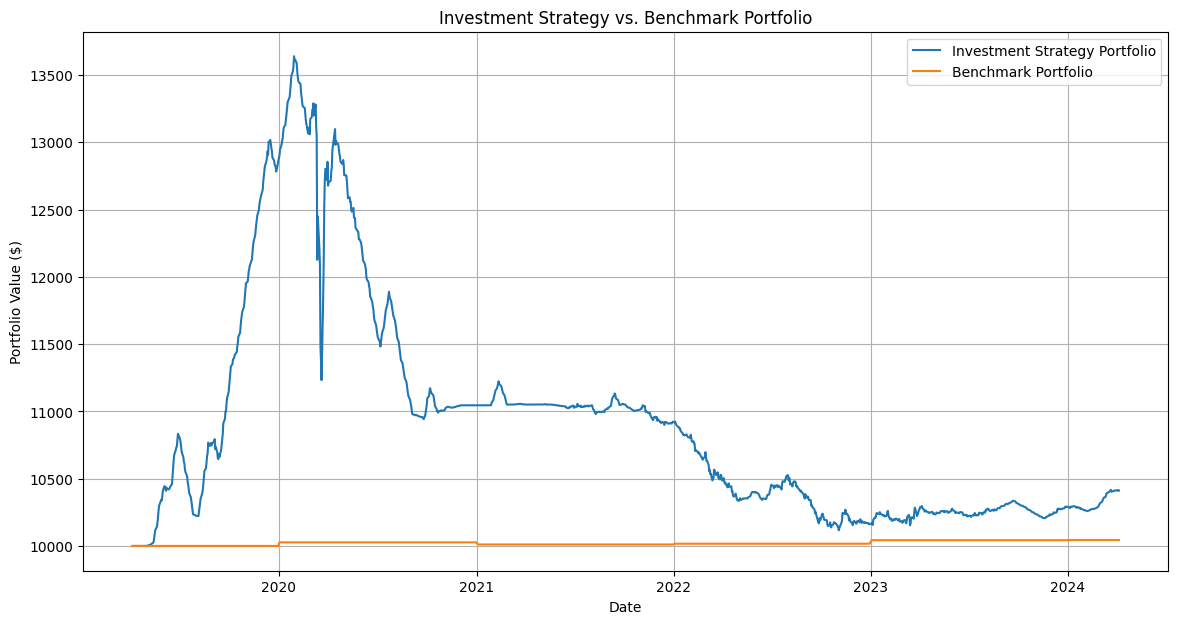

Sharpe Ratio: 1.0688954361113816
Sortino Ratio: 1.6322770340674058
Value at Risk (95% confidence): -0.0031109344264134142
Annualized Volatility: 0.06194099800882856
Maximum Drawdown: -0.2583483061749887
Beta: 0.49080891029719237
Skewness: -3.4172025590292012
Portfolio Returns: Date
2019-12-31    0.286587
2020-12-31   -0.141489
2021-12-31   -0.011063
2022-12-31   -0.069759
2023-12-31    0.012670
2024-12-31    0.011914
Freq: YE-DEC, Name: Portfolio Value, dtype: float64
{'AMZN': 13, 'V': 14, 'TSLA': 0, 'UNH': 13, 'AAPL': 7, 'NVDA': 14, 'LLY': 28, 'XOM': 9, 'JPM': 6}
90.72899999999508


In [120]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged data
merged_df = pd.read_csv('merged.csv', parse_dates=['Date'])
merged_df.set_index('Date', inplace=True)

# Make sure all financial data is float
financial_cols = [col for col in merged_df.columns if 'Price' in col or 'Yield' in col]
merged_df[financial_cols] = merged_df[financial_cols].astype(float)

# Calculate SMAs for each company's spread
companies = set(col.split('-')[0] for col in merged_df.columns if 'Price' in col)
calculate_smas(merged_df)

# Backtest the strategy starting from 5 years ago
start_date = merged_df.index.max() - pd.DateOffset(years=5)
backtest_data = merged_df.loc[start_date:]
portfolio_value_df, holdings, cash = backtest_strategy_with_interest(backtest_data)

# Calculate the benchmark portfolio
benchmark_portfolio_df = calculate_benchmark_portfolio(backtest_data)

# Combine the backtest portfolio and benchmark portfolio
combined_portfolio_df = pd.concat([portfolio_value_df, benchmark_portfolio_df], axis=1)

# Calculate daily returns
daily_returns = portfolio_value_df['Portfolio Value'].pct_change().dropna()
# Assuming a constant risk-free rate of 0.5% annually for simplicity
annual_returns = (1 + daily_returns).resample('Y').prod() - 1
risk_free_rate_annual = 0.005
trading_days = 252
average_annual_return = annual_returns.mean()
#daily_risk_free_return = risk_free_rate / trading_days
# Calculate excess returns for the Sharpe and Sortino ratios
excess_annual_returns = annual_returns - risk_free_rate_annual

#sharpe
sharpe_ratio = excess_annual_returns.mean() / excess_annual_returns.std() * np.sqrt(trading_days)

#sortino
# Calculate the downside deviation
negative_excess_returns = excess_annual_returns[excess_annual_returns < 0]
downside_deviation = np.sqrt(negative_excess_returns.pow(2).mean())
sortino_ratio = excess_annual_returns.mean() / downside_deviation * np.sqrt(trading_days)

#Value at risk
VaR_95 = daily_returns.quantile(0.05)

#vol
volatility = daily_returns.std() * np.sqrt(trading_days)

#max drawdown
roll_max = portfolio_value_df['Portfolio Value'].cummax()
daily_drawdown = portfolio_value_df['Portfolio Value']/roll_max - 1.0
max_drawdown = daily_drawdown.min()

#beta
benchmark_returns = benchmark_portfolio_df['Benchmark Portfolio'].pct_change().dropna()
covariance = np.cov(daily_returns, benchmark_returns)[0][1]
benchmark_variance = benchmark_returns.var()
beta = covariance / benchmark_variance

#skewness
skewness = daily_returns.skew()

# Plotting the comparison
plt.figure(figsize=(14, 7))
plt.plot(combined_portfolio_df.index, combined_portfolio_df['Portfolio Value'], label='Investment Strategy Portfolio')
plt.plot(combined_portfolio_df.index, combined_portfolio_df['Benchmark Portfolio'], label='Benchmark Portfolio')
plt.title('Investment Strategy vs. Benchmark Portfolio')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

#portfolio performance metrics and other stats
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Sortino Ratio: {sortino_ratio}")
print(f"Value at Risk (95% confidence): {VaR_95}")
print(f"Annualized Volatility: {volatility}")
print(f"Maximum Drawdown: {max_drawdown}")
print(f"Beta: {beta}")
print(f"Skewness: {skewness}")
print(f"Portfolio Returns: {annual_returns}")

# Print final holdings and cash
print(holdings)
print(cash)
